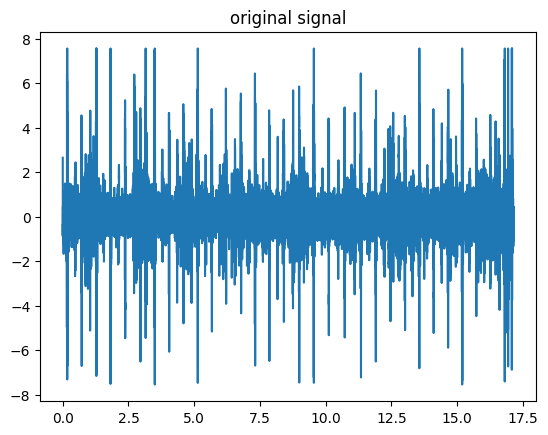

In [72]:
from cement.utils import fs
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import wavfile



def load_wav(wav_path):
    sample_rate, data = wavfile.read(wav_path)
    return sample_rate, data
def pre_process(data):
    R=3
    data=data/np.std(data)
    abs_data_sorted=-np.sort(-1*np.abs(data))# sort in descending order
    TH=np.mean(abs_data_sorted[0:int(0.1*len(data))])
    for i in range(0,len(data)):
        if np.abs(data[i]) > R*TH:
            data[i] = R*TH
    data=data/np.std(data)
    return data
def plot_signal(data,title):
    plt.plot(np.linspace(0, len(data)/samplerate, len(data)), data)
    plt.title(title)
    plt.show()
    return


data_path='./data/23306_AV.wav'
samplerate, data = load_wav(data_path)
data=pre_process(data)
#data=data[2*samplerate:6*samplerate]
plot_signal(data,'original signal')
data_time_eva=data[2*samplerate:6*samplerate]

## Phase 1(reference sound detection)

### (A) periodicity in time domain

In [38]:
def divide_freq_space(freq_low, freq_high, n_band,
                          divide_type='ERB'):
        """Divide frequency range (freq_low~freq_high) equally in erb
        scale(default)
        Args:
            freq_low: low bound of frequency range
            freq_high: high bound of frequency range
            n_band: segments number frequency range to be divided
            divide_type: default to ERB
        """
        if divide_type == 'ERB':
            if n_band == 1:
                return np.asarray(freq_low, dtype=float).reshape(1, )
            print(freq_low)
            low_erb = Hz2ERBscal(freq_low)
            high_erb = Hz2ERBscal(freq_high)
            erb_elem = (high_erb-low_erb)/(n_band-1)
            f = ERBscal2Hz(low_erb+erb_elem*np.arange(n_band))
        else:
            raise Exception('unsupport Divide type')
        return f
def Hz2ERBscal(freq):
        """convert Hz to ERB scale"""
        return 21.4*np.log10(4.37*freq/1e3+1)

def ERBscal2Hz(erb_num):
        """convert ERB scale to Hz"""
        return (10**(erb_num/21.4)-1)/4.37*1e3
def cal_ERB(cf):
        return 24.7*(4.37*cf/1000+1.0)
def cal_bw(cf):
        erb = cal_ERB(cf)
        return 1.019*erb

In [39]:
def filter(T,input,freq_low,freq_high):
    cf=divide_freq_space(freq_low, freq_high, 1)
    n = np.arange(len(input))
    shiftor = np.exp(1j * 2 * np.pi * cf * n *T)
    input_prime=input * shiftor
    b=float(cal_bw(cf)[0])
    k=np.exp(-2*np.pi*b*T)
    numerator = np.array([0, 1, 4*k, k**2],dtype=complex)
    denominator = np.array([1, -4*k, 6*k**2, -4*k**3, k**4],dtype=complex)
    numerator = np.array([T**3 * coef for coef in numerator],dtype=complex)
    output_prime= lfilter(numerator, denominator, input_prime)
    output=np.real(output_prime/shiftor)
    return output

In [40]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [41]:
from scipy.signal import correlate
def normalized_correlation(x, w):
    numerator = correlate(x * w, x * w, mode="full")
    denominator = correlate(w , w , mode="full")
    denominator[denominator == 0] = 1e-5

    return numerator / denominator


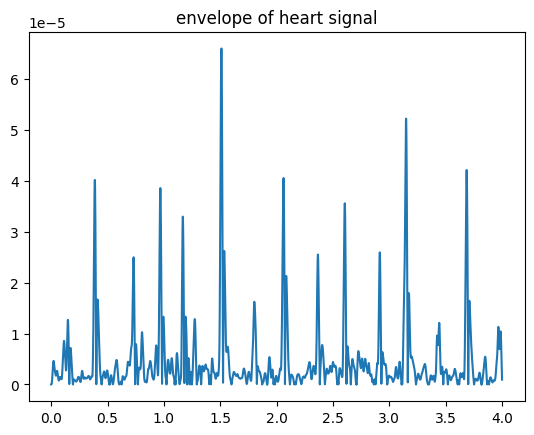

In [42]:
# extract envelop of HS components by Hilbert transform and Gammatone band-pass filter and auto correlation
from scipy.signal import hilbert
from scipy.signal import lfilter

envelope=np.abs(hilbert(data_time_eva))
envelope=np.abs(filter(T=1/samplerate,input=envelope,freq_low=10,freq_high=1000))
plot_signal(envelope,'envelope of heart signal')

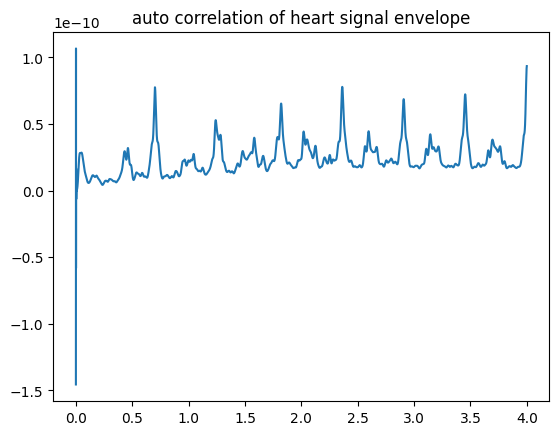

In [131]:
win=np.hanning(envelope.shape[0])
corr=normalized_correlation(envelope,win)
corr=corr[0:int(len(corr)/2)]
plot_signal(corr,'auto correlation of heart signal envelope')

- Periodicity check criterion 1

$$\cos(\theta) = \frac{\langle y_r(\tau), y_{r+1}(\tau) \rangle}{|y_r(\tau)| |y_{r+1}(\tau)|}$$

- It is considered that two consecutive heart cycles exhibit similar shapes if their internal product is greater than 0.8

In [164]:
# select the prominent peaks
# estimate heart beat 75/min
from scipy.signal import find_peaks

def find_promin_peaks(signal,fs,est_heart_cycle,init):
    window_size=int(fs*est_heart_cycle)

    peaks,property=find_peaks(signal)
    peaks=peaks[peaks>init*fs]
    highest_peak = peaks[np.argmax(signal[peaks])]

    selected_peaks = [highest_peak]

    num_heart_cycles = int(len(signal) /window_size)

    def find_adjacent_peak(reference_peak, direction):
        if direction == -1:
            window_start, window_end = max(0, reference_peak - window_size), reference_peak
        else:
            window_start, window_end = reference_peak, min(len(signal), reference_peak + window_size)

        candidates = [p for p in peaks if (window_start < p < window_end) and (np.abs(p-reference_peak)>window_size/2)]
        if candidates:
            return max(candidates, key=lambda p: signal[p])
        return None


    while len(selected_peaks) < num_heart_cycles:
        for peak in selected_peaks:
            left_peak = find_adjacent_peak(peak, -1)
            if left_peak and left_peak not in selected_peaks:
                selected_peaks.append(left_peak)
                if len(selected_peaks) >= num_heart_cycles:
                    break
            right_peak = find_adjacent_peak(peak, 1)
            if right_peak and right_peak not in selected_peaks:
                selected_peaks.append(right_peak)
                if len(selected_peaks) >= num_heart_cycles:
                    break
    return selected_peaks

promin_peaks=find_promin_peaks(corr,samplerate,0.8,0.5)
print([int(x) for x in promin_peaks])


[9450, 7281, 11630, 4960]


In [45]:
# checking for internal product
def cosine_similarity(y_r, y_r1):

    inner_product = np.dot(y_r, y_r1)
    norm_y_r = np.linalg.norm(y_r)
    norm_y_r1 = np.linalg.norm(y_r1)

    # Avoid division by zero
    if norm_y_r == 0 or norm_y_r1 == 0:
        return 0  # Or handle as needed

    return inner_product / (norm_y_r * norm_y_r1)

### Periodicity in time-frequency domain

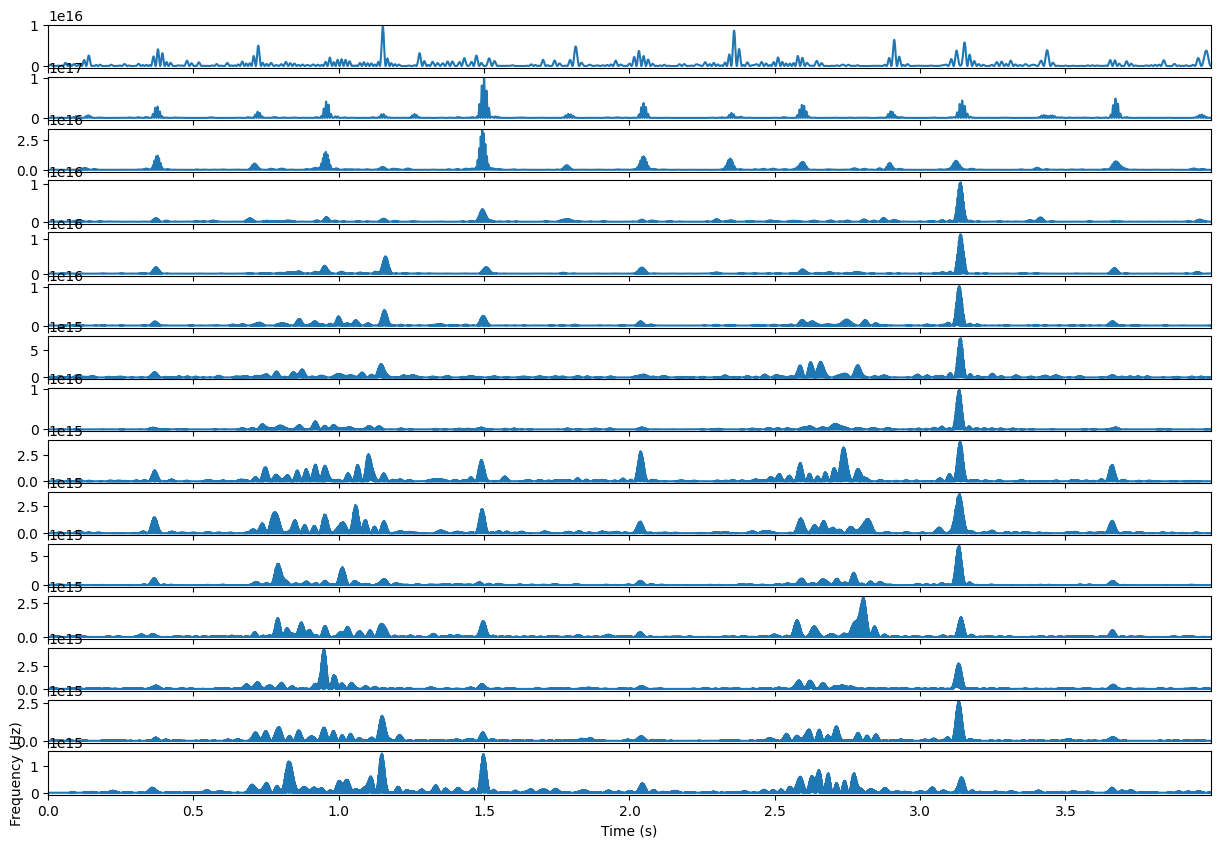

In [122]:
# STFT for the signal(with window function) and divide into 15 frequency bands in 0-600Hz and calculate spectral energy
from scipy.signal import ShortTimeFFT
def fre_bands_spectrum(signal,fs):
    N=len(signal)
    x=np.linspace(0, N - 1, N)
    win_temp=np.hanning(N)
    win=np.array([0 if idx > N / 2 else x for x,idx in enumerate(win_temp)])
    SFT=ShortTimeFFT(win=win,fs=fs,hop=1)
    STFT=np.real(SFT.stft(signal))
    y_lo=int((STFT.shape[1]+1)/4)
    y_hi=int((STFT.shape[1])*0.75)
    temp=STFT[:2400,y_lo:y_hi]
    fre_bands=temp.reshape(15,160,temp.shape[1]).sum(axis=1)
    fig, axes = plt.subplots(15, 1, figsize=(15, 10), sharex=True)

    for i in range(15):
        fre_bands[i]=[j**2 for j in fre_bands[i]]
        axes[i].plot(np.linspace(0,fre_bands.shape[1]/samplerate,fre_bands.shape[1]),fre_bands[i], label=f"Row {i+1}")
        plt.xlim(0,fre_bands.shape[1]/samplerate)
    axes[-1].set_xlabel("Time (s)")
    axes[-1].set_ylabel("Frequency (Hz)")
    plt.show()
    return fre_bands

a=fre_bands_spectrum(data_time_eva,samplerate)

In [103]:
from scipy.linalg import svd
def SVD_eva(m):
    theta=svd(m,compute_uv=False)
    phi=(theta[1]/theta[0])**2
    return phi

In [109]:
# auto correlation of each frequency band
as_k_len=2*a.shape[1]-1
as_k = np.zeros((15,as_k_len))
sg_1=np.zeros((5,a.shape[1]))
sg_6=np.zeros((5,a.shape[1]))
sg_11=np.zeros((5,a.shape[1]))
phi_sg=np.zeros(3)
for i in range(15):
    as_k[i]=np.correlate(a[i],a[i],mode="full")
    if i<=4:
        sg_1[i]=as_k[i][:a.shape[1]]
    elif i<=9:
        sg_6[i-5]=as_k[i][:a.shape[1]]
    else :
        sg_11[i-10]=as_k[i][:a.shape[1]]
phi_sg=[SVD_eva(sg_1),SVD_eva(sg_6),SVD_eva(sg_11)]
print([float(x) for x in phi_sg])


[0.0018167025189109157, 0.046284906847908584, 0.04704191927840567]


In [178]:
## peak alignment

num_of_peaks=int(a.shape[1]/samplerate/0.8)
peaks_in_fre_bands=np.zeros((15,num_of_peaks))
for i in range(15):
    peaks_in_fre_bands[i]=find_promin_peaks(as_k[i][:a.shape[1]],samplerate,0.8,0)

num_of_aligned_peaks=0
for j in range(num_of_peaks):
    flag=0
    standard=peaks_in_fre_bands[0][j]
    low_limit=standard*0.95
    high_limit=standard*1.05
    for k in range(1,15):
        if peaks_in_fre_bands[k][j] < low_limit or peaks_in_fre_bands[k][j] > high_limit:
            flag=1
            break
    if flag==0:
        num_of_aligned_peaks=num_of_aligned_peaks+1
print(num_of_aligned_peaks)

1
